In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Loading The Train Data**

In [1]:
import pandas as pd

In [3]:
Ml_Train=pd.read_csv('/kaggle/input/upgraded-version/ML_Train_Data.csv')
Ml_Train.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay,IncidentGrade
0,7,6,InitialAccess,T1078;T1078.004,Ip,Related,4,Morning,TruePositive
1,58,43,Exfiltration,T1041,User,Impacted,14,Early Morning,FalsePositive
2,423,298,InitialAccess,T1189,Url,Related,13,Early Morning,FalsePositive
3,2,2,CommandAndControl,T1046;T1071;T1210,Url,Related,10,Evening,BenignPositive
4,9,74,Execution,T1559;T1106;T1059.005,User,Impacted,15,Early Morning,TruePositive


**Loading The Test Data**

In [4]:
Ml_Test=pd.read_csv('/kaggle/input/upgraded-version/ML_Test_DataV1.csv')
Ml_Test.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay,IncidentGrade
0,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,User,Impacted,4,Night,BenignPositive
1,2,2,CommandAndControl,T1046;T1030;T1071;T1071.001,Machine,Impacted,3,Afternoon,BenignPositive
2,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,Process,Related,8,Early Morning,BenignPositive
3,0,0,InitialAccess,T1078;T1078.004,CloudLogonSession,Related,12,Afternoon,FalsePositive
4,27,18,Discovery,T1087;T1087.002,User,Impacted,6,Evening,BenignPositive


**Some Data in the Test Data is not Present in the Train Data So Droping the unwanted Data from the TestData**

In [5]:
import pandas as pd

# Step 1: Identify new (unseen) values in Ml_Test['MitreTechniques']
# Values in Ml_Test['MitreTechniques'] that are not in Ml_Train['MitreTechniques']
new_values = Ml_Test['MitreTechniques'][~Ml_Test['MitreTechniques'].isin(Ml_Train['MitreTechniques'].unique())]

# Step 2: Calculate how many rows have new (unseen) values
num_new_values = len(new_values)
print(f"Number of rows in Ml_Test['MitreTechniques'] with new (unseen) values: {num_new_values}")

# Step 3: Drop rows with new (unseen) values from Ml_Test
Ml_Test_cleaned = Ml_Test[~Ml_Test['MitreTechniques'].isin(new_values)]

# Optionally, you can directly update the original Ml_Test by dropping the rows
Ml_Test.drop(Ml_Test[Ml_Test['MitreTechniques'].isin(new_values)].index, inplace=True)

# Print the updated test dataframe and its size
print(f"Rows after dropping new values: {len(Ml_Test)}")


Number of rows in Ml_Test['MitreTechniques'] with new (unseen) values: 1951
Rows after dropping new values: 4146041


In [6]:
Ml_Test.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay,IncidentGrade
0,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,User,Impacted,4,Night,BenignPositive
1,2,2,CommandAndControl,T1046;T1030;T1071;T1071.001,Machine,Impacted,3,Afternoon,BenignPositive
3,0,0,InitialAccess,T1078;T1078.004,CloudLogonSession,Related,12,Afternoon,FalsePositive
4,27,18,Discovery,T1087;T1087.002,User,Impacted,6,Evening,BenignPositive
5,0,0,InitialAccess,T1078;T1078.004,User,Impacted,6,Morning,TruePositive


**Now Let's Do the Encoding**


> Since in 4 Columns there are more unique Categorical values and that are not ordinal as well so doing the Label encoding won't be a sutiable and model can able to miscalculate that there is a rank based relation between the category present in the Columns And doing the One hot encoding also a effective or the reliable solution it will Increase the Dimension of the Data so I will Go with the Frequency Encoding

In [7]:
import pandas as pd
import pickle

# Categorical columns to be frequency encoded
frequency_encoding_columns = ['Category', 'MitreTechniques', 'EntityType', 'EvidenceRole']

# Frequency Encoding for ML_Train
category_mappings = {}

for column in frequency_encoding_columns:
    # Get frequency distribution based on ML_Train data
    frequency_map = Ml_Train[column].value_counts(normalize=True)
    
    # Map frequencies to a new column in ML_Train
    Ml_Train[column + '_freq'] = Ml_Train[column].map(frequency_map)
    
    # Store the frequency mappings to apply on ML_Test later
    category_mappings[column] = frequency_map.to_dict()

# Drop the original categorical columns if needed from ML_Train
# Ml_Train.drop(columns=frequency_encoding_columns, inplace=True)

# Now, apply the same mappings to ML_Test
for column in frequency_encoding_columns:
    # Use the frequency mappings calculated from ML_Train
    freq_col_name = column + '_freq'
    Ml_Test[freq_col_name] = Ml_Test[column].map(category_mappings[column])
    
    # Fill any NaN values in case a category in ML_Test is not found in ML_Train
    Ml_Test[freq_col_name] = Ml_Test[freq_col_name].fillna(0)

# Drop the original categorical columns if needed from ML_Test
# Ml_Test.drop(columns=frequency_encoding_columns, inplace=True)

# Optionally save the mappings to a pickle file for future use
with open(r'Freq_enco_mapping.pkl', 'wb') as f:
    pickle.dump(category_mappings, f)

print("Frequency encoding applied to ML_Train and ML_Test, and mappings saved to pickle file!")

Frequency encoding applied to ML_Train and ML_Test, and mappings saved to pickle file!


In [10]:
Ml_Test.isnull().sum()/len(Ml_Test)*100

DetectorId              0.0
AlertTitle              0.0
Category                0.0
MitreTechniques         0.0
EntityType              0.0
EvidenceRole            0.0
Day                     0.0
PartOfDay               0.0
IncidentGrade           0.0
Category_freq           0.0
MitreTechniques_freq    0.0
EntityType_freq         0.0
EvidenceRole_freq       0.0
dtype: float64

**Let's Cross Validated whether Both the Train and the Test Data Are encoded Properly**

In [11]:
Ml_Train.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay,IncidentGrade,Category_freq,MitreTechniques_freq,EntityType_freq,EvidenceRole_freq
0,7,6,InitialAccess,T1078;T1078.004,Ip,Related,4,Morning,TruePositive,0.452709,0.259097,0.230436,0.550274
1,58,43,Exfiltration,T1041,User,Impacted,14,Early Morning,FalsePositive,0.163832,0.161817,0.199259,0.449726
2,423,298,InitialAccess,T1189,Url,Related,13,Early Morning,FalsePositive,0.452709,0.000233,0.072112,0.550274
3,2,2,CommandAndControl,T1046;T1071;T1210,Url,Related,10,Evening,BenignPositive,0.087224,0.075662,0.072112,0.550274
4,9,74,Execution,T1559;T1106;T1059.005,User,Impacted,15,Early Morning,TruePositive,0.028186,0.021806,0.199259,0.449726


In [12]:
Ml_Test.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay,IncidentGrade,Category_freq,MitreTechniques_freq,EntityType_freq,EvidenceRole_freq
0,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,User,Impacted,4,Night,BenignPositive,0.004352,0.000008,0.199259,0.449726
1,2,2,CommandAndControl,T1046;T1030;T1071;T1071.001,Machine,Impacted,3,Afternoon,BenignPositive,0.087224,0.003039,0.073704,0.449726
3,0,0,InitialAccess,T1078;T1078.004,CloudLogonSession,Related,12,Afternoon,FalsePositive,0.452709,0.259097,0.022437,0.550274
4,27,18,Discovery,T1087;T1087.002,User,Impacted,6,Evening,BenignPositive,0.013523,0.007330,0.199259,0.449726
5,0,0,InitialAccess,T1078;T1078.004,User,Impacted,6,Morning,TruePositive,0.452709,0.259097,0.199259,0.449726


**There some Ordinal Relationship between the category present in the PartofDay And the IncidentGrade So I will do a Label Encoding for those Columns**

In [13]:
# Import label encoder 
from sklearn import preprocessing 
a=['PartOfDay','IncidentGrade']
label_encoder = preprocessing.LabelEncoder() 
for i in a:
    Ml_Train[i]= label_encoder.fit_transform(Ml_Train[i]) 
    print(Ml_Train[i].unique())
    Ml_Test[i]= label_encoder.transform(Ml_Test[i]) 
    print(Ml_Test[i].unique())

[3 1 2 0 4]
[4 0 2 3 1]
[2 1 0]
[0 1 2]


In [14]:
Ml_Train.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay,IncidentGrade,Category_freq,MitreTechniques_freq,EntityType_freq,EvidenceRole_freq
0,7,6,InitialAccess,T1078;T1078.004,Ip,Related,4,3,2,0.452709,0.259097,0.230436,0.550274
1,58,43,Exfiltration,T1041,User,Impacted,14,1,1,0.163832,0.161817,0.199259,0.449726
2,423,298,InitialAccess,T1189,Url,Related,13,1,1,0.452709,0.000233,0.072112,0.550274
3,2,2,CommandAndControl,T1046;T1071;T1210,Url,Related,10,2,0,0.087224,0.075662,0.072112,0.550274
4,9,74,Execution,T1559;T1106;T1059.005,User,Impacted,15,1,2,0.028186,0.021806,0.199259,0.449726


In [15]:
Ml_Test.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay,IncidentGrade,Category_freq,MitreTechniques_freq,EntityType_freq,EvidenceRole_freq
0,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,User,Impacted,4,4,0,0.004352,0.000008,0.199259,0.449726
1,2,2,CommandAndControl,T1046;T1030;T1071;T1071.001,Machine,Impacted,3,0,0,0.087224,0.003039,0.073704,0.449726
3,0,0,InitialAccess,T1078;T1078.004,CloudLogonSession,Related,12,0,1,0.452709,0.259097,0.022437,0.550274
4,27,18,Discovery,T1087;T1087.002,User,Impacted,6,2,0,0.013523,0.007330,0.199259,0.449726
5,0,0,InitialAccess,T1078;T1078.004,User,Impacted,6,3,2,0.452709,0.259097,0.199259,0.449726


**Save The Label Encoded File Similarly like the Frequency Encoded.**

In [ ]:
Ml_Test.to_csv("Fre_encoded.csv",index=False)

**Now the Rename and Drop the old Columns for better understand and Model training**


**Dropping the Old Columns**

In [16]:
Ml_Train.drop(['Category','MitreTechniques','EntityType','EvidenceRole'],axis=1,inplace = True)

In [17]:
Ml_Test.drop(['Category','MitreTechniques','EntityType','EvidenceRole'],axis=1,inplace = True)

**Renaming the columns with the old names For Better Understanding**

In [20]:
Ml_Train.rename(columns={'Category_freq':'Category', 
                         'MitreTechniques_freq':'MitreTechniques', 
                         'EntityType_freq':'EntityType', 
                         'EvidenceRole_freq':'EvidenceRole'}, inplace=True)


In [21]:
Ml_Test.rename(columns={'Category_freq':'Category', 
                         'MitreTechniques_freq':'MitreTechniques', 
                         'EntityType_freq':'EntityType', 
                         'EvidenceRole_freq':'EvidenceRole'}, inplace=True)


In [22]:
Ml_Train.head()

,DetectorId,AlertTitle,Day,PartOfDay,IncidentGrade,Category,MitreTechniques,EntityType,EvidenceRole
0,7,6,4,3,2,0.452709,0.259097,0.230436,0.550274
1,58,43,14,1,1,0.163832,0.161817,0.199259,0.449726
2,423,298,13,1,1,0.452709,0.000233,0.072112,0.550274
3,2,2,10,2,0,0.087224,0.075662,0.072112,0.550274
4,9,74,15,1,2,0.028186,0.021806,0.199259,0.449726


In [23]:
Ml_Test.head()

,DetectorId,AlertTitle,Day,PartOfDay,IncidentGrade,Category,MitreTechniques,EntityType,EvidenceRole
0,524,563,4,4,0,0.004352,0.000008,0.199259,0.449726
1,2,2,3,0,0,0.087224,0.003039,0.073704,0.449726
3,0,0,12,0,1,0.452709,0.259097,0.022437,0.550274
4,27,18,6,2,0,0.013523,0.007330,0.199259,0.449726
5,0,0,6,3,2,0.452709,0.259097,0.199259,0.449726


**Seggregate the Features and Targets**

In [26]:
Features=Ml_Train[['DetectorId','AlertTitle','Category','MitreTechniques','EntityType','EvidenceRole','Day','PartOfDay']]
Features.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay
0,7,6,0.452709,0.259097,0.230436,0.550274,4,3
1,58,43,0.163832,0.161817,0.199259,0.449726,14,1
2,423,298,0.452709,0.000233,0.072112,0.550274,13,1
3,2,2,0.087224,0.075662,0.072112,0.550274,10,2
4,9,74,0.028186,0.021806,0.199259,0.449726,15,1


In [28]:
Features.shape

(9465497, 8)

In [27]:
Target=Ml_Train['IncidentGrade']
Target

0          2
1          1
2          1
3          0
4          2
          ..
9465492    2
9465493    0
9465494    0
9465495    0
9465496    0
Name: IncidentGrade, Length: 9465497, dtype: int64

**Spliting the Dataset for test and train**

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Features,Target, test_size=0.3,random_state=42,stratify=Target)

**Strandardizing or Normalizing the Features since the columns are in different ranges**

In [30]:
from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)
print(X_test_scaled)

[[-0.25414475 -0.2542803   1.07505475 ...  0.90373393 -0.77930601
   1.44118819]
 [-0.08694142  0.01723301 -0.52843868 ... -1.10652036 -0.61710641
  -1.20422702]
 [-0.18248618  0.03080409 -0.52843868 ... -1.10652036 -0.94150562
  -1.20422702]
 ...
 [-0.25414475 -0.2542803   1.07505475 ...  0.90373393 -1.10370522
  -0.54287322]
 [-0.16098861 -0.25189619 -1.28138642 ...  0.90373393 -1.10370522
   0.77983439]
 [-0.24220165 -0.24969548 -0.85435196 ...  0.90373393  0.031692
   1.44118819]]
[[-0.25175613 -0.25418861  1.07505475 ... -1.10652036  0.68049042
  -0.54287322]
 [-0.18726342 -0.25253807  1.07505475 ... -1.10652036  0.68049042
  -1.20422702]
 [-0.1848748  -0.25244637 -0.99752325 ...  0.90373393  3.43788368
   0.11848059]
 ...
 [ 0.35256447  1.52059699 -0.52843868 ... -1.10652036 -0.61710641
  -1.20422702]
 [-0.23981303 -0.25382182  1.07505475 ... -1.10652036  0.68049042
   0.77983439]
 [-0.25414475 -0.2542803   1.07505475 ...  0.90373393 -1.10370522
   0.77983439]]


**Saving or Pickling the StandardScaler Knowledge Since it will be Used for Scale the Test Data**

In [31]:
import pickle

# Save the model to a file using Pickle
with open('Scale.pkl', 'wb') as file:
   pickle.dump(scaler, file)

**Let's inspect whether all the class in the dataset have a equally present**

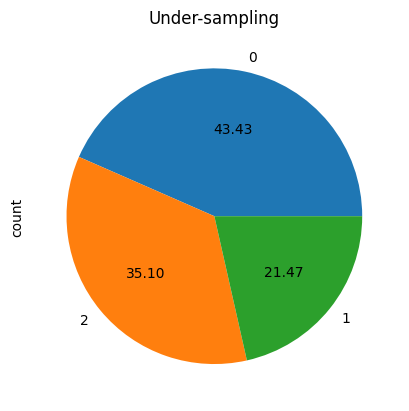

In [32]:
y_train.value_counts()

ax = y_train.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

**Seems Like the 0th Class have more number of data when compare to the other Class let's do the undersampling**

In [33]:
!pip install imbalanced-learn

**Doing the Random UnderSampling**

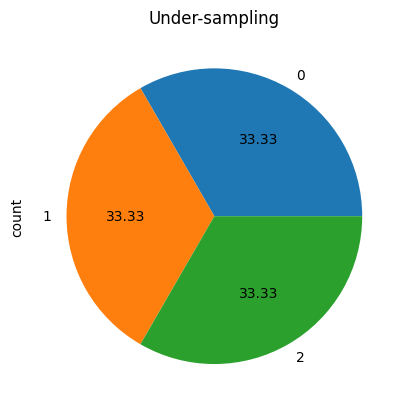

In [34]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler() # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)


ax = y_train_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [35]:
!pip install xgboost

**Let Train the 7 Different model and Check which model Performs well and based on the Best performing model lets do the Other Process**

In [36]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

# Initialize the models
model_lr = LogisticRegression(random_state=42)
model_dt = DecisionTreeClassifier(random_state=42)
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)


# Fit each model
model_lr.fit(X_train_rus, y_train_rus)
model_dt.fit(X_train_rus, y_train_rus)
model_rf.fit(X_train_rus, y_train_rus)


RandomForestClassifier(random_state=42)

In [37]:
model_gb = GradientBoostingClassifier(n_estimators=150, random_state=42)
model_knn = KNeighborsClassifier(n_neighbors=4)
model_sgd = SGDClassifier(random_state=42)
model_xgb = XGBClassifier(random_state=42)

model_gb.fit(X_train_rus, y_train_rus)
model_knn.fit(X_train_rus, y_train_rus)
model_sgd.fit(X_train_rus, y_train_rus)
model_xgb.fit(X_train_rus, y_train_rus)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

**Now I have Trained the Model let's Evaluate the Model and check whether My model can able to Generalize well or not**

In [38]:
# Import required metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# List of models and their names
models = {
    "Logistic Regression": model_lr,
    "Decision Tree": model_dt,
    "Random Forest": model_rf,
    "Gradient Boosting": model_gb,
    "K-Nearest Neighbors": model_knn,
    "SGD Classifier": model_sgd,
    "XGBoost": model_xgb
}

# Loop through each model and evaluate
for name, model in models.items():
    print(f"Evaluating {name}:")
    
    # Predict on the test set 
    y_pred = model.predict(X_test_scaled)
    
    # Accuracy Score
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\n" + "="*60 + "\n")


Evaluating Logistic Regression:
Accuracy: 0.5317
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.60      0.61   1233246
           1       0.25      0.30      0.27    609590
           2       0.65      0.58      0.62    996814

    accuracy                           0.53   2839650
   macro avg       0.50      0.50      0.50   2839650
weighted avg       0.55      0.53      0.54   2839650

Confusion Matrix:
[[745597 346939 140710]
 [252988 181131 175471]
 [220212 193531 583071]]


Evaluating Decision Tree:
Accuracy: 0.8282
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86   1233246
           1       0.77      0.77      0.77    609590
           2       0.85      0.79      0.82    996814

    accuracy                           0.83   2839650
   macro avg       0.82      0.82      0.82   2839650
weighted avg       0.83      0.83      0.83   2839650

Confusi

**After Evaluating the Model Performance the Model such as Randam Forest, Decision Tree, XGBoost are Performing Considerabaly well so I will Take This Model for the furthur Processs**

In [39]:
# Import required metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# List of models and their names
models = {
    #"Logistic Regression": model_lr,
    "Decision Tree": model_dt,
    "Random Forest": model_rf,
    #"Gradient Boosting": model_gb,
    #"K-Nearest Neighbors": model_knn,
    #"SGD Classifier": model_sgd,
    "XGBoost": model_xgb
}

# Loop through each model and evaluate
for name, model in models.items():
    print(f"Validataing {name}:")
    
    # Predict on the train set 
    y_pred_val = model.predict(X_train_rus)
    
    # Accuracy Score
    acc = accuracy_score(y_train_rus,y_pred_val)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_train_rus,y_pred_val))
    
    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_train_rus,y_pred_val))
    
    print("\n" + "="*60 + "\n")


Validataing Decision Tree:
Accuracy: 0.8222
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84   1422377
           1       0.86      0.78      0.82   1422377
           2       0.83      0.79      0.81   1422377

    accuracy                           0.82   4267131
   macro avg       0.83      0.82      0.82   4267131
weighted avg       0.83      0.82      0.82   4267131

Confusion Matrix:
[[1276566   74799   71012]
 [ 155625 1103023  163729]
 [ 195629   97787 1128961]]


Validataing Random Forest:
Accuracy: 0.8222
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84   1422377
           1       0.86      0.78      0.82   1422377
           2       0.83      0.80      0.81   1422377

    accuracy                           0.82   4267131
   macro avg       0.83      0.82      0.82   4267131
weighted avg       0.83      0.82      0.82   4267131

Co

**Lets Compare the Three model**

In [58]:
Model=['Decision_Tree','Random_Forest','Xtream_GB']
R2_Evalu=[82.82,82.18,79]
R2_validation=[82.22,82.22,77]

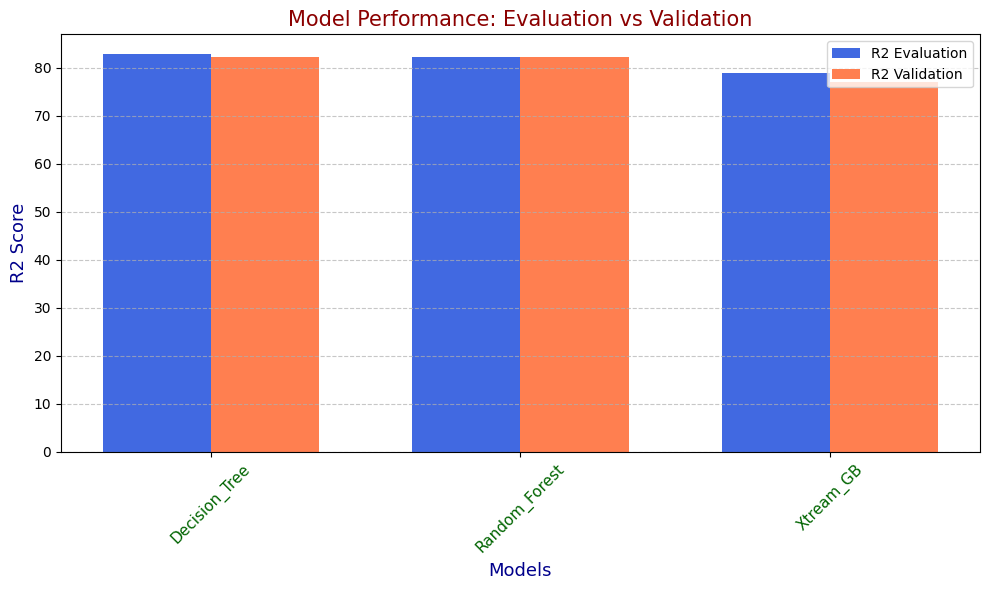

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plotting the grouped bar chart
bar_width = 0.35
index = np.arange(len(Model))

plt.bar(index, R2_Evalu, width=bar_width, color='royalblue', label='R2 Evaluation')
plt.bar(index + bar_width, R2_validation, width=bar_width, color='coral', label='R2 Validation')

# Labeling the chart
plt.xlabel('Models', fontsize=13, color='darkblue')
plt.ylabel('R2 Score', fontsize=13, color='darkblue')
plt.title('Model Performance: Evaluation vs Validation', fontsize=15, color='darkred')

# Adding model names
plt.xticks(index + bar_width / 2, Model, rotation=45, fontsize=11, color='darkgreen')

# Adding a legend and grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


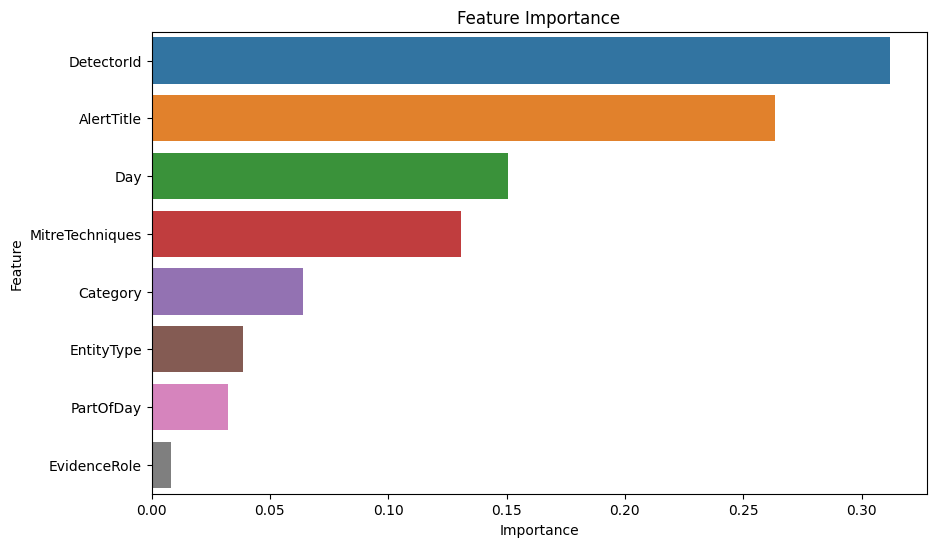

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


feature_importance = model_rf.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sorting the features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


**By seeing this the EvidenceRolw is getting the Least Importance when compare to Other**

In [40]:
import pickle


# Save the model to a file using Pickle
with open('Random_forest_model.pkl', 'wb') as file:
   pickle.dump(model_rf, file)

In [41]:
import pickle


# Save the model to a file using Pickle
with open('DecisionTree_model.pkl', 'wb') as file:
   pickle.dump(model_dt, file)

In [42]:
import pickle


# Save the model to a file using Pickle
with open('XtreameGB_model.pkl', 'wb') as file:
   pickle.dump(model_xgb, file)

Now Let Do a Evaluation on the Actuall Test(unseen) Dataset

In [44]:
import pandas as pd

**Loading the Model**

In [46]:
Ml_evalu=pd.read_csv('/kaggle/input/test-evaluating/Fre_encoded.csv')
Ml_evalu.head()

,DetectorId,AlertTitle,Day,PartOfDay,IncidentGrade,Category,MitreTechniques,EntityType,EvidenceRole
0,524,563,4,4,0,0.004352,0.000008,0.199259,0.449726
1,2,2,3,0,0,0.087224,0.003039,0.073704,0.449726
2,0,0,12,0,1,0.452709,0.259097,0.022437,0.550274
3,27,18,6,2,0,0.013523,0.007330,0.199259,0.449726
4,0,0,6,3,2,0.452709,0.259097,0.199259,0.449726


**Loading the pickled StandardScaler for Doing the Standardization**

In [47]:
import pickle
import pandas as pd

# Load the scaler
with open('/kaggle/input/test-evaluating/Scale (1).pkl', 'rb') as f:
    scaler = pickle.load(f)

**Splitting the Target And Feature**

In [48]:
Target=Ml_evalu['IncidentGrade']
print(Target)

0          0
1          0
2          1
3          0
4          2
          ..
4146036    0
4146037    0
4146038    1
4146039    0
4146040    2
Name: IncidentGrade, Length: 4146041, dtype: int64


In [49]:
features =Ml_evalu[['DetectorId','AlertTitle','Category','MitreTechniques','EntityType','EvidenceRole','Day','PartOfDay']]
features.head()


,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay
0,524,563,0.004352,0.000008,0.199259,0.449726,4,4
1,2,2,0.087224,0.003039,0.073704,0.449726,3,0
2,0,0,0.452709,0.259097,0.022437,0.550274,12,0
3,27,18,0.013523,0.007330,0.199259,0.449726,6,2
4,0,0,0.452709,0.259097,0.199259,0.449726,6,3


**Applying the Standardization**

In [50]:
X_test_scaled = scaler.transform(features)
print(X_test_scaled)

[[ 0.99749158 -0.20265518 -1.41368248 ... -1.10652036 -0.94150562
   1.44118819]
 [-0.24936751 -0.25409691 -0.95367809 ... -1.10652036 -1.10370522
  -1.20422702]
 [-0.25414475 -0.2542803   1.07505475 ...  0.90373393  0.35609121
  -1.20422702]
 ...
 [-0.11799347 -0.2516211  -0.95367809 ...  0.90373393  0.84269002
  -0.54287322]
 [-0.25175613 -0.25418861  1.07505475 ... -1.10652036  0.19389161
   0.11848059]
 [-0.25175613 -0.25418861  1.07505475 ... -1.10652036 -0.94150562
   0.11848059]]


**Now Load the Model and Test whether My trained Model Can Able to generalize**

In [52]:
import pickle
import pandas as pd

with open('/kaggle/input/test-evaluating/DecisionTree_model.pkl', 'rb') as f:
    Model = pickle.load(f)

In [53]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions with the trained model
y_pred = Model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(Target, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

# Print classification report
report = classification_report(Target, y_pred)
print("Classification Report:\n", report)

# Print confusion matrix
conf_matrix = confusion_matrix(Target, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79   1751475
           1       0.64      0.68      0.66    902345
           2       0.80      0.67      0.73   1492221

    accuracy                           0.74   4146041
   macro avg       0.73      0.73      0.73   4146041
weighted avg       0.74      0.74      0.74   4146041

Confusion Matrix:
 [[1452408  175204  123863]
 [ 168075  611792  122478]
 [ 326438  162638 1003145]]


In [54]:
import pickle
import pandas as pd

with open('/kaggle/input/test-evaluating/Random_forest_model (1).pkl', 'rb') as f:
    Model1 = pickle.load(f)

In [55]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions with the trained model
y_pred = Model1.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(Target, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

# Print classification report
report = classification_report(Target, y_pred)
print("Classification Report:\n", report)

# Print confusion matrix
conf_matrix = confusion_matrix(Target, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80   1751475
           1       0.66      0.65      0.66    902345
           2       0.84      0.69      0.76   1492221

    accuracy                           0.76   4146041
   macro avg       0.75      0.74      0.74   4146041
weighted avg       0.76      0.76      0.75   4146041

Confusion Matrix:
 [[1512681  152092   86702]
 [ 202157  587294  112894]
 [ 312561  144360 1035300]]


In [56]:
import pickle
import pandas as pd

with open('/kaggle/input/test-evaluating/XtreameGB_model.pkl', 'rb') as f:
    Model2 = pickle.load(f)

In [57]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions with the trained model
y_pred = Model2.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(Target, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

# Print classification report
report = classification_report(Target, y_pred)
print("Classification Report:\n", report)

# Print confusion matrix
conf_matrix = confusion_matrix(Target, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.72
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76   1751475
           1       0.55      0.69      0.61    902345
           2       0.85      0.66      0.74   1492221

    accuracy                           0.72   4146041
   macro avg       0.71      0.71      0.70   4146041
weighted avg       0.74      0.72      0.72   4146041

Confusion Matrix:
 [[1366038  325004   60433]
 [ 166353  619318  116674]
 [ 321800  180175  990246]]


**Final Comparision**

In [61]:
Model=['Decision_Tree','Random_Forest','Xtream_GB']
R2_Evalu_Train=[82.82,82.18,79]
R2_Evalu_Test=[74,76,72]

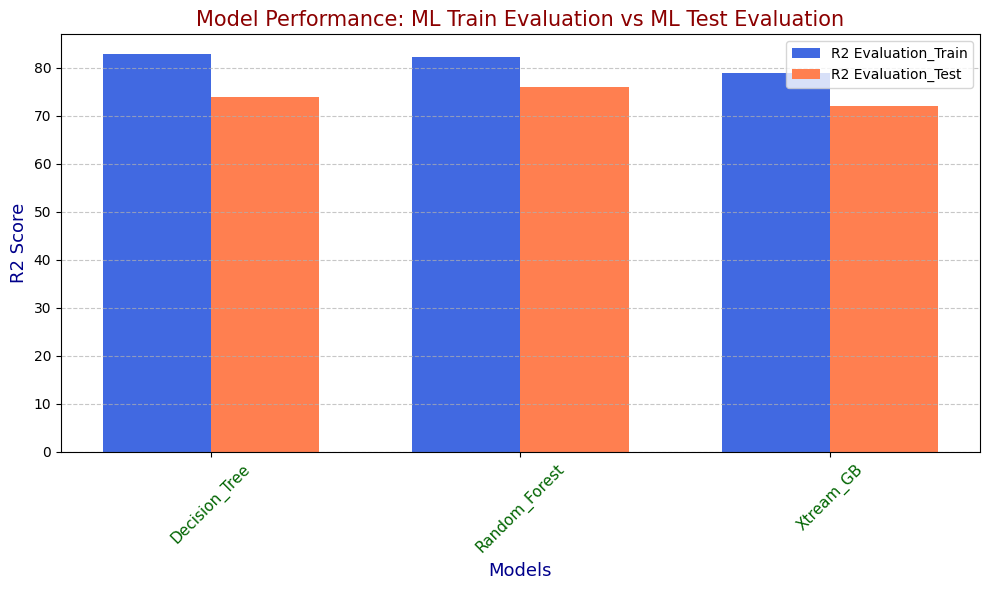

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plotting the grouped bar chart
bar_width = 0.35
index = np.arange(len(Model))

plt.bar(index, R2_Evalu_Train, width=bar_width, color='royalblue', label='R2 Evaluation_Train')
plt.bar(index + bar_width, R2_Evalu_Test, width=bar_width, color='coral', label='R2 Evaluation_Test')

# Labeling the chart
plt.xlabel('Models', fontsize=13, color='darkblue')
plt.ylabel('R2 Score', fontsize=13, color='darkblue')
plt.title('Model Performance: ML Train Evaluation vs ML Test Evaluation', fontsize=15, color='darkred')

# Adding model names
plt.xticks(index + bar_width / 2, Model, rotation=45, fontsize=11, color='darkgreen')

# Adding a legend and grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# Conclusion

> I have also Done a Grid Search Cv But  the accuracy Have Not increased and while evaluation in the unseen data(Test Data) it give around 70 - 75% accuracy and there is also slightly struggling to generalize so What I will do Is based On the Feature importance let's check the model can able to generalize well or Not